### **Table of contents :**

**1-similarity** 

- Identify attackers who have the same behavior 
- which campaigns have the most common techniques ? Are they using techniques the same way?
- which exploitable target a specific compaign may target in the future ? (link prediction with 2 methods)


**2- Centrality**

- Which products have the highest number of vulnerabilities?
- Which techniques are observed most often? 
- which actors are the most active? 

**3- Use case**

The organisation have noticed a clue or evidence of a data breach: 
- what techniques are being used in the attack ? 
- what should be done to stop the attack? 
- The priority should be given to which techniques?


Note : Les commandes sont en langage cypher. 

### **The Neo4j Graph Data Science (GDS) library**

The Neo4j Graph Data Science (GDS) library contains many graph algorithms. The algorithms are divided into categories which represent different problem classes.

In [1]:
!pip install py2neo

In [2]:
from py2neo import Graph, Node, Relationship, NodeMatcher
import csv
import pandas as pd                               

**Etablir la connexion avec l'instance DB neo4j créée**



In [8]:
graph=Graph('bolt://localhost:7687', auth=('neo4j', 'password'))

Project named graph - project entire graph with undirected / Natural or reverse relationships ( depending on the type of the question to solve )

In [55]:
q= """CALL gds.graph.project(
  'projection_',
['Attacker','AttackerGRP','Campaign','DATE','ExploitTargetObject','Features','Groups','Indicator','Information','Location','Malware','Mitigations','Organisation','Product','Tactics','Techniques','Vulnerability'],
  {
    belongsto: {
      type: 'belongsto',
      orientation: 'UNDIRECTED'
    },
    prevents: {
      type: 'Prevents',
      orientation: 'UNDIRECTED'
    },
    accomplishes: {
      type: 'Accomplishes',
      orientation: 'UNDIRECTED'
    },
      step: {
      type: 'Step',
      orientation: 'UNDIRECTED'
    },
      uses: {
      type: 'Uses',
      orientation: 'UNDIRECTED'
    },
      associatedto: {
      type: 'associatedTo',
      orientation: 'UNDIRECTED'
    },
      authored: {
      type: 'authored',
      orientation: 'UNDIRECTED'
    },
      exploits: {
      type: 'exploits',
      orientation: 'UNDIRECTED'
    },
      hasattacklocation: {
      type: 'hasattacklocation',
      orientation: 'UNDIRECTED'
    },
      hasattacktime: {
      type: 'hasattacktime',
      orientation: 'UNDIRECTED'
    },
      hascharacteristics: {
      type: 'hascharacteristics',
      orientation: 'UNDIRECTED'
    },
      hasproduct: {
      type: 'hasproduct',
      orientation: 'UNDIRECTED'
    },
      hasvulnerability: {
      type: 'hasvulnerability',
      orientation: 'UNDIRECTED'
    },
      indicates: {
      type: 'indicates',
      orientation: 'UNDIRECTED'
    },
      involvesmalware: {
      type: 'involvesmalware',
      orientation: 'REVERSE'
    },
      targets: {
      type: 'targets',
      orientation: 'UNDIRECTED'
    },
      usesmalware: {
      type: 'usesmalware',
      orientation: 'UNDIRECTED'
    }
  }
) YIELD nodeCount, relationshipCount """

graph.run(q)

nodeCount,relationshipCount
22419,56740


# Part 1 - **Centrality**

**1- Which products have the highest number of vulnerabilities?**

Let's create our sub-graph projection first , since I have to focus only on Product & Vulnerability nodes as well as their relationship to answer the question. So, I will filter my projected graph : In GDS, algorithms can be executed on a named graph that has been filtered based on its node labels and relationship types. However, that filtered graph only exists during the execution of the algorithm, and it is not possible to filter on property values. If a filtered graph needs to be used multiple times, one can use the subgraph catalog procedure to project a new graph in the graph catalog.

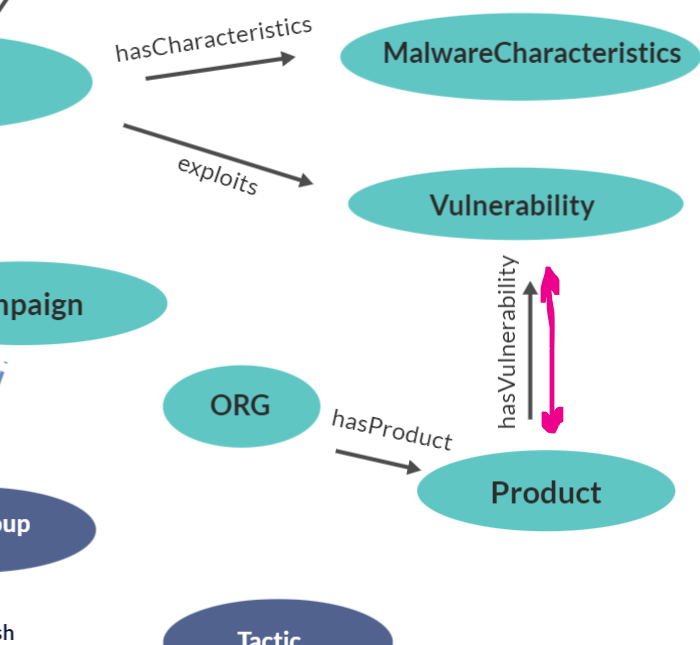

In [15]:
q="""CALL gds.beta.graph.project.subgraph(
  'product_',
  'projectgraph',
  'n:Product OR n:Vulnerability',
  'r:hasvulnerability'
)
YIELD graphName, fromGraphName, nodeCount, relationshipCount
"""

graph.run(q)

graphName,fromGraphName,nodeCount,relationshipCount
product_,projectgraph,1603,68


## PageRank 

The PageRank algorithm measures the importance of each node within the graph, based on the number incoming relationships and the importance of the corresponding source nodes. The underlying assumption roughly speaking is that a page is only as important as the pages that link to it.



In [16]:
q= '''CALL gds.pageRank.write.estimate('product_', {
          writeProperty: 'pageRank',
          maxIterations: 20,
          dampingFactor: 0.85
        })
        YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory'''


graph.run(q)

nodeCount,relationshipCount,bytesMin,bytesMax,requiredMemory
1603,68,39464,39464,38 KiB


In [17]:
q = """CALL gds.pageRank.stream('product_')
        YIELD nodeId, score
        MATCH (a:Product)
        WHERE gds.util.asNode(nodeId).Name=a.Name
        with gds.util.asNode(nodeId).Name as Product, score
        //Match(a:Product) where id(a) = nodeId
        //set a.Rank =score
        return Product,score
        ORDER BY score DESC
        """

df = pd.DataFrame(graph.query(q).to_data_frame()) 
print("\nPAGE RANKING ALGORITHM")
display(df.head(10))


PAGE RANKING ALGORITHM


,Product,score
0,Windows,1.844543
1,Debian Linux,1.402891
2,Chrome,0.961240
3,Ubunutu Linux,0.961240
4,Fedora,0.961240
5,Excel,0.961240
6,Mac Os X,0.961240
7,WinMain,0.961240
8,Entreprise Linux Desktop,0.961240
9,Leap,0.961240


#### **2. Which techniques are observed most often?**

The idea is to identify techniques with highest usage -> popularity of the nodes in the graph

### **Degree Centrality**

The Degree Centrality algorithm can be used to find popular nodes within a graph. Degree centrality measures the number of incoming or outgoing (or both) relationships from a node, depending on the orientation of a relationship projection. For more information on relationship orientations, see the relationship projection syntax section. It can be applied to either weighted or unweighted graphs. In the weighted case the algorithm computes the sum of all positive weights of adjacent relationships of a node, for each node in the graph. Non-positive weights are ignored.



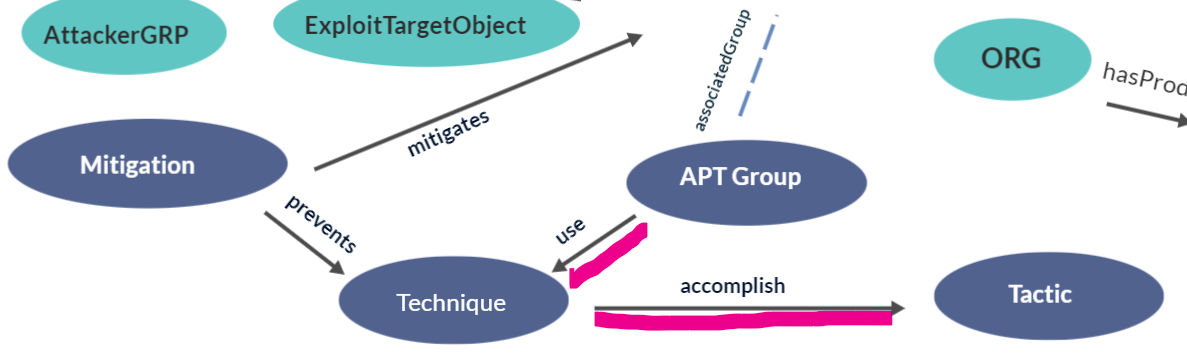

In [19]:
q="""CALL gds.beta.graph.project.subgraph(
  'tec',
  'project',
  'n:Groups OR n:Techniques OR n:Tactics',
  'r:uses OR r:accomplishes'
)
YIELD graphName, fromGraphName, nodeCount, relationshipCount
"""

graph.run(q)

graphName,fromGraphName,nodeCount,relationshipCount
tec,project,282,1715


In [20]:
q="""CALL gds.degree.write.estimate('tec', { writeProperty: 'degree' })
YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory
"""

graph.run(q)

nodeCount,relationshipCount,bytesMin,bytesMax,requiredMemory
282,1715,56,56,56 Bytes


In [21]:
q='''CALL gds.degree.stream('tec')
YIELD nodeId, score
MATCH (a:Techniques)
WHERE gds.util.asNode(nodeId).Name=a.Name
RETURN gds.util.asNode(nodeId).Name AS name, score AS usage
ORDER BY usage DESC
'''

df = pd.DataFrame(graph.query(q).to_data_frame()) 
print("\nDEGREE CENTRALITY ALGORITHM")
display(df.head(10))


DEGREE CENTRALITY ALGORITHM


,name,usage
0,Valid Accounts,4.0
1,Scheduled Task/Job,3.0
2,Hijack Execution Flow,3.0
3,Traffic Signaling,3.0
4,External Remote Services,2.0
5,Replication Through Removable Media,2.0
6,Software Deployment Tools,2.0
7,BITS Jobs,2.0
8,Boot or Logon Autostart Execution,2.0
9,Boot or Logon Initialization Scripts,2.0


#### **which actors are the most active?**

**method : Degree centrality**

In [58]:
q="""CALL gds.degree.write.estimate('attack_graph', { writeProperty: 'degree' })
YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory
"""

graph.run(q)

nodeCount,relationshipCount,bytesMin,bytesMax,requiredMemory
11825,29108,56,56,56 Bytes


In [60]:
q='''CALL gds.degree.stream('attack_graph')
YIELD nodeId, score
MATCH (a:Attacker)
WHERE gds.util.asNode(nodeId).Name=a.Name
RETURN gds.util.asNode(nodeId).Name AS name, score AS usage
ORDER BY usage DESC
'''

df = pd.DataFrame(graph.query(q).to_data_frame()) 
print("\nDEGREE CENTRALITY ALGORITHM")
display(df.head(10))


DEGREE CENTRALITY ALGORITHM


,name,usage
0,Kevin Mitnick,183.0
1,Fadia,118.0
2,Trojan,112.0
3,Turla,94.0
4,APT,94.0
5,Pakistan,82.0
6,Microsoft,74.0
7,Lazarus,69.0
8,France,66.0
9,2009,66.0


# Part 2 - Similarity

**1. Identify attackers who have the same behavior**

The Node Similarity algorithm compares a set of nodes based on the nodes they are connected to. Two nodes are considered similar if they share many of the same neighbors. Node Similarity computes pair-wise similarities based on either the Jaccard metric, also known as the Jaccard Similarity Score, or the Overlap coefficient, also known as the Szymkiewicz–Simpson coefficient.


In [338]:
q="""CALL gds.graph.project(
    'Graph',
    ['Attacker', 'Malware', 'Location', 'Information'],
    {
        authored: {
            type: 'authored'
        },
        hasattacklocation: {
            type:'hasattacklocation'
        },
        hasproduct : {
            type:'hasproduct'
        }
    }
); """

graph.run(q)

nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
"{Attacker: {label: 'Attacker', properties: {}}, Malware: {label: 'Malware', properties: {}}, Information: {label: 'Information', properties: {}}, Location: {label: 'Location', properties: {}}}","{authored: {orientation: 'NATURAL', aggregation: 'DEFAULT', type: 'authored', properties: {}}, hasattacklocation: {orientation: 'NATURAL', aggregation: 'DEFAULT', type: 'hasattacklocation', properties: {}}, hasproduct: {orientation: 'NATURAL', aggregation: 'DEFAULT', type: 'hasproduct', properties: {}}}",Graph,9438,9091,15


In [339]:
q="""CALL gds.nodeSimilarity.write.estimate('Graph', {
  writeRelationshipType: 'SIMILAR',
  writeProperty: 'score'
})
YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory """

graph.run(q)

nodeCount,relationshipCount,bytesMin,bytesMax,requiredMemory
9438,9091,2870528,3097040,[2803 KiB ... 3024 KiB]


In [342]:
q="""CALL gds.nodeSimilarity.stream('Graph', { topK: 1 })
YIELD node1, node2, similarity
MATCH (a1:Attacker)
MATCH (a2:Attacker)
WHERE gds.util.asNode(node1).Name=a1.Name and gds.util.asNode(node2).Name=a2.Name and a1<>a2
RETURN id(gds.util.asNode(node1)) AS id_Attacker1, id(gds.util.asNode(node2)) AS id_Attacker2, similarity
ORDER BY similarity DESCENDING, id_Attacker1, id_Attacker2"""

df = pd.DataFrame(graph.query(q).to_data_frame()) 
print("\nNode Similarity")
display(df)


Node Similarity


,id_Attacker1,id_Attacker2,similarity
0,1745,3992,1.000000
1,1756,1844,1.000000
2,1758,1821,1.000000
3,1759,1786,1.000000
4,1770,3355,1.000000
...,...,...,...
3889,3868,2010,0.027778
3890,5569,2010,0.026316
3891,7680,1811,0.021739
3892,4616,1811,0.021277


**Which group of campaigns have the most common techniques ? Are they using techniques the same way?**

In [169]:
q="""CALL gds.beta.graph.project.subgraph(
  'tech',
  'projected_graph',
  'n:Groups OR n:Techniques',
  'r:uses'
)
YIELD graphName, fromGraphName, nodeCount, relationshipCount
"""

graph.run(q)

graphName,fromGraphName,nodeCount,relationshipCount
tech,projected_graph,270,3052


In [170]:
q="""CALL gds.nodeSimilarity.write.estimate('tech', {
  writeRelationshipType: 'SIMILAR',
  writeProperty: 'score'
})
YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory """

graph.run(q)

nodeCount,relationshipCount,bytesMin,bytesMax,requiredMemory
270,3052,106072,136312,[103 KiB ... 133 KiB]


In [172]:
q="""CALL gds.nodeSimilarity.stream('tech', { topK: 1 })
YIELD node1, node2, similarity
MATCH (a1:Groups)
MATCH (a2:Groups)
WHERE gds.util.asNode(node1).Name=a1.Name and gds.util.asNode(node2).Name=a2.Name and a1<>a2
RETURN gds.util.asNode(node1).Name AS Group1, gds.util.asNode(node2).Name AS Group2, similarity
ORDER BY similarity DESCENDING, Group1, Group2"""

df = pd.DataFrame(graph.query(q).to_data_frame()) 
print("\nNode Similarity")
display(df.head(20))


Node Similarity


,Group1,Group2,similarity
0,BlackOasis,Moafee,1.000000
1,Moafee,BlackOasis,1.000000
2,APT30,Mofang,0.666667
3,Mofang,APT30,0.666667
4,Gorgon Group,Sharpshooter,0.583333
5,Sharpshooter,Gorgon Group,0.583333
6,APT-C-36,Rancor,0.500000
7,APT12,TA459,0.500000
8,BlackTech,TA459,0.500000
9,GCMAN,Orangeworm,0.500000


In [173]:
df

,Group1,Group2,similarity
0,BlackOasis,Moafee,1.000000
1,Moafee,BlackOasis,1.000000
2,APT30,Mofang,0.666667
3,Mofang,APT30,0.666667
4,Gorgon Group,Sharpshooter,0.583333
...,...,...,...
96,Thrip,DarkVishnya,0.200000
97,Winnti Group,Molerats,0.181818
98,Cleaver,Axiom,0.166667
99,Equation,Strider,0.166667


**Are they using those techniques same way ?**

### **Which exploitable target a compaign may target in the future ?**

The idea is to predict campaigns who may be similar (already involved in the same malware or shared the same target) then to predict for each campaign the probability to target a specific exploitable object based on its relationship with other campaigns

## Link Prediction - Method 1

### Preprocessing

In [223]:
q= """CALL gds.graph.project(
  'projection',
['Attacker','AttackerGRP','Campaign','DATE','ExploitTargetObject','Features','Groups','Indicator','Information','Location','Malware','Mitigations','Organisation','Product','Tactics','Techniques','Vulnerability'],
  {
    belongsto: {
      type: 'belongsto',
      orientation: 'UNDIRECTED'
    },
    prevents: {
      type: 'Prevents',
      orientation: 'UNDIRECTED'
    },
      accomplishes: {
      type: 'Accomplishes',
      orientation: 'UNDIRECTED'
    },
      step: {
      type: 'Step',
      orientation: 'UNDIRECTED'
    },
      uses: {
      type: 'Uses',
      orientation: 'UNDIRECTED'
    },
      associatedto: {
      type: 'associatedTo',
      orientation: 'UNDIRECTED'
    },
      authored: {
      type: 'authored',
      orientation: 'UNDIRECTED'
    },
      exploits: {
      type: 'exploits',
      orientation: 'UNDIRECTED'
    },
      hasattacklocation: {
      type: 'hasattacklocation',
      orientation: 'UNDIRECTED'
    },
      hasattacktime: {
      type: 'hasattacktime',
      orientation: 'UNDIRECTED'
    },
      hascharacteristics: {
      type: 'hascharacteristics',
      orientation: 'UNDIRECTED'
    },
      hasproduct: {
      type: 'hasproduct',
      orientation: 'UNDIRECTED'
    },
      hasvulnerability: {
      type: 'hasvulnerability',
      orientation: 'UNDIRECTED'
    },
      indicates: {
      type: 'indicates',
      orientation: 'UNDIRECTED'
    },
      involvesmalware: {
      type: 'involvesmalware',
      orientation: 'UNDIRECTED'
    },
      targets: {
      type: 'targets',
      orientation: 'UNDIRECTED'
    },
      usesmalware: {
      type: 'usesmalware',
      orientation: 'UNDIRECTED'
    }
  }
) YIELD nodeCount, relationshipCount """

graph.run(q)

nodeCount,relationshipCount
22419,57808


Since we have already projected the entire graph at the beginning, let's mutate the graph project with fastRP embedding

### Fast Random Projection Embedding

Fast Random Projection (FastRP) is a scalable and performant node-embedding algorithm. It generates node embeddings (vectors) of low dimensionality through random projections from the graph’s adjacency matrix (a high-dimensional matrix) to a low-dimensional matrix, significantly reducing the computing power required to process the data.

**Why FastRP embedding ?**

This algorithm is especially useful in the following situations:

- Your data is in such high dimension that it is too expensive to perform calculations.

- The dimensionality is very high and the number of samples are too sparse to calculate covariances.

- You don’t have access to the entire dataset, such as when working with real-time data.

In [224]:
q="""
CALL gds.fastRP.mutate(
  'projection',
  {
    mutateProperty: 'embedding',
    relationshipTypes: ['belongsto' , 'targets','involvesmalware','accomplishes','prevents','step','uses','associatedto','authored','exploits','hasattacklocation','hasattacktime','hascharacteristics','hasproduct','hasvulnerability','indicates','usesmalware'],
    iterationWeights: [0.0, 1.0, 0.7, 0.5, 0.5, 0.4],
    embeddingDimension: 128,
    randomSeed: 7474
  }
) YIELD nodePropertiesWritten, computeMillis;"""

graph.run(q)

nodePropertiesWritten,computeMillis
22419,221


#### Building the co-attack graph

The dataset doesn’t contain relationships between campaigns describing their relationship, but we can infer them based on finding malwares involved by multiple campaigns. The code below creates a CO_ATTACK relationship between campaigns that have involved on at least one common malware:

In [222]:
q="""MATCH (a1:Campaign)-[:involvesmalware]-(:Malware)-[:involvesmalware]-(a2:Campaign) 
MERGE (a1)-[:CO_ATTACK]-(a2)"""

graph.run(q)

(No data)

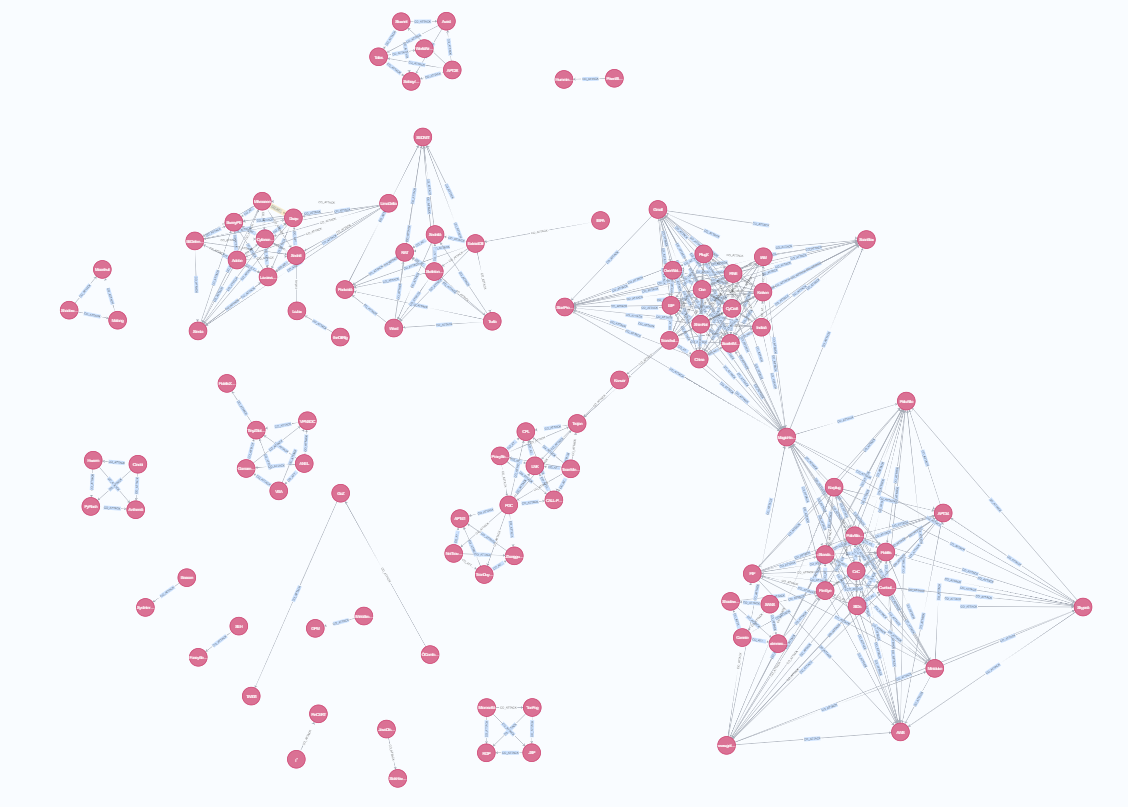

#### Configure Link Prediction Pipeline

In [225]:
q="""CALL gds.beta.pipeline.linkPrediction.create('er-pipe');
"""

graph.run(q)

name,nodePropertySteps,featureSteps,splitConfig,parameterSpace
er-pipe,[],[],"{negativeSamplingRatio: 1.0, testFraction: 0.1, validationFolds: 3, trainFraction: 0.1}","{RandomForest: [], LogisticRegression: []}"


add l2 link feature

In [226]:
q="""CALL gds.beta.pipeline.linkPrediction.addFeature(
  'er-pipe',
  'l2',
  {
    nodeProperties: ['embedding']
  }
) YIELD featureSteps;"""

graph.run(q)

featureSteps
"[{name: 'L2', config: {nodeProperties: ['embedding']}}]"


add cosin link feature

In [227]:
q="""CALL gds.beta.pipeline.linkPrediction.addFeature(
  'er-pipe',
  'cosine',
  {
    nodeProperties: ['embedding']
  }
) YIELD featureSteps;"""

graph.run(q)

featureSteps
"[{name: 'L2', config: {nodeProperties: ['embedding']}}, {name: 'COSINE', config: {nodeProperties: ['embedding']}}]"


configure relationship splits

In [228]:
q="""CALL gds.beta.pipeline.linkPrediction.configureSplit(
  'er-pipe',
  {
    testFraction: 0.3,
    trainFraction: 0.7,
    negativeSamplingRatio: 10,
    validationFolds: 5
  }
) YIELD splitConfig;"""

graph.run(q)

splitConfig
"{negativeSamplingRatio: 10.0, testFraction: 0.3, validationFolds: 5, trainFraction: 0.7}"


Configure model parameters

In [229]:
q="""CALL gds.beta.pipeline.linkPrediction.addLogisticRegression(
  'er-pipe',
  {
    penalty: 0.0,
    patience: 3,
    maxEpochs: 2000,
    tolerance: 0.00001
  }
) YIELD parameterSpace;"""

graph.run(q)

parameterSpace
"{RandomForest: [], LogisticRegression: [{maxEpochs: 2000, minEpochs: 1, penalty: 0.0, patience: 3, methodName: 'LogisticRegression', batchSize: 100, tolerance: 1e-05}]}"


In [230]:
q="""CALL gds.beta.pipeline.linkPrediction.addLogisticRegression(
  'er-pipe',
  {
    penalty: 0.01,
    patience: 3,
    maxEpochs: 1000,
    tolerance: 0.00001
  }
) YIELD parameterSpace;"""

graph.run(q)

parameterSpace
"{RandomForest: [], LogisticRegression: [{maxEpochs: 2000, minEpochs: 1, penalty: 0.0, patience: 3, methodName: 'LogisticRegression', batchSize: 100, tolerance: 1e-05}, {maxEpochs: 1000, minEpochs: 1, penalty: 0.01, patience: 3, methodName: 'LogisticRegression', batchSize: 100, tolerance: 1e-05}]}"


In [231]:
q="""CALL gds.beta.pipeline.linkPrediction.addLogisticRegression(
  'er-pipe',
  {
    penalty: 1.0,
    patience: 3,
    maxEpochs: 1000,
    tolerance: 0.00001
  }
) YIELD parameterSpace;"""

graph.run(q)

parameterSpace
"{RandomForest: [], LogisticRegression: [{maxEpochs: 2000, minEpochs: 1, penalty: 0.0, patience: 3, methodName: 'LogisticRegression', batchSize: 100, tolerance: 1e-05}, {maxEpochs: 1000, minEpochs: 1, penalty: 0.01, patience: 3, methodName: 'LogisticRegression', batchSize: 100, tolerance: 1e-05}, {maxEpochs: 1000, minEpochs: 1, penalty: 1.0, patience: 3, methodName: 'LogisticRegression', batchSize: 100, tolerance: 1e-05}]}"


### Train model

In [232]:
q="""CALL gds.beta.pipeline.linkPrediction.train(
  'projection',
  {
    modelName: 'entity-linkage-model',
    pipeline: 'er-pipe',
    randomSeed: 7474,
    concurrency: 4,
    nodeLabels: ['Campaign'],
    relationshipTypes: ['COATTACK'],
    negativeClassWeight: 1.0/10.0
  }
) YIELD modelInfo
RETURN
    modelInfo.bestParameters AS winningModel,
    modelInfo.metrics.AUCPR.outerTrain AS trainGraphScore,
    modelInfo.metrics.AUCPR.test AS testGraphScore;"""

graph.run(q)

winningModel,trainGraphScore,testGraphScore
"{maxEpochs: 2000, minEpochs: 1, penalty: 0.0, patience: 3, methodName: 'LogisticRegression', batchSize: 100, tolerance: 1e-05}",0.9884708114492939,0.9878000589039964


### Use pipeline for prediction

In [24]:
q="""CALL gds.beta.pipeline.linkPrediction.predict.mutate(
  'projection',
  {
    modelName: 'entity-linkage-model',
    mutateRelationshipType: 'MayTarget',
    nodeLabels: ['Temp_node'],
    relationshipTypes: ['targets'],
    topN: 100,
    threshold: 0.0
  }
);"""

graph.run(q)

ClientError: [Procedure.ProcedureCallFailed] Failed to invoke procedure `gds.beta.pipeline.linkPrediction.predict.mutate`: Caused by: java.lang.IllegalArgumentException: Procedure requires relationship projections to be UNDIRECTED. Projection for `targets` uses orientation `NATURAL`

In [234]:
q="""CALL gds.graph.writeRelationship('projection', 'CO-ATTACK', 'probability');"""

graph.run(q)

writeMillis,graphName,relationshipType,relationshipProperty,relationshipsWritten,propertiesWritten
52,projection,CO-ATTACK,probability,400,400


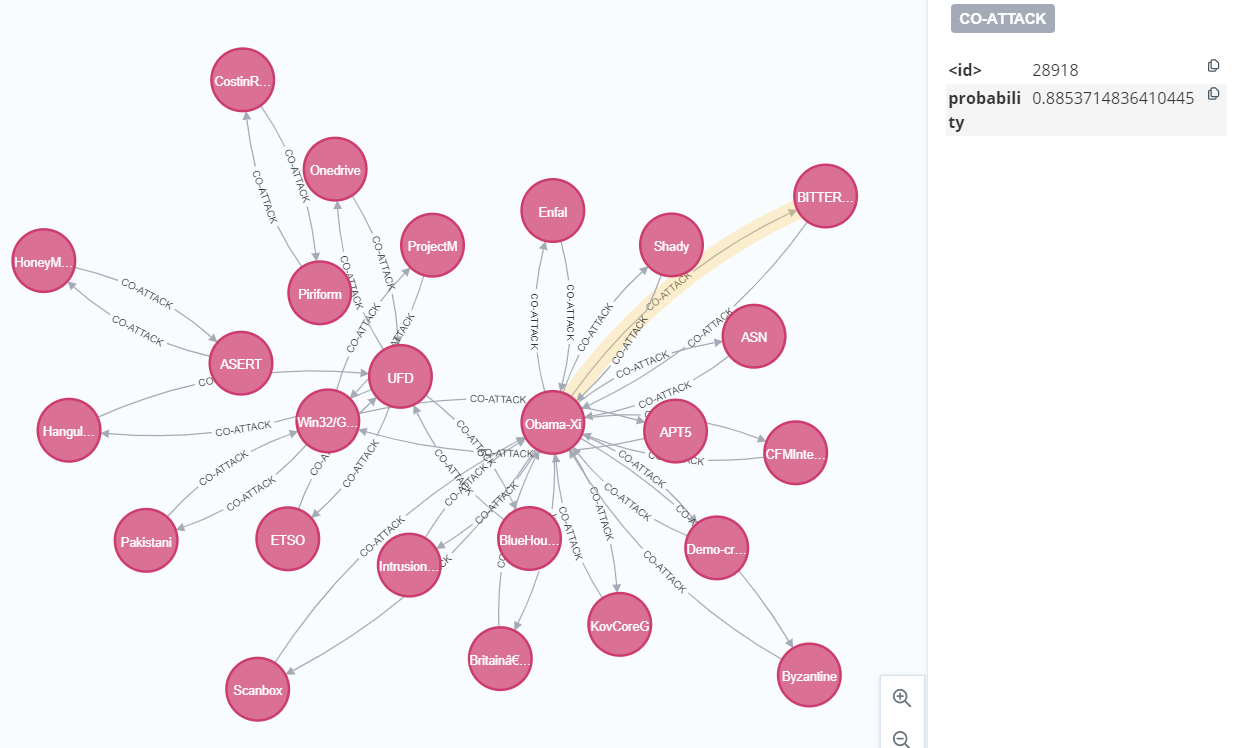

Undirected relationships will have a relationship for each direction, we only need one

In [210]:
q="""MATCH (n:Campaign)-[r:`CO-ATTACK`]->(m:Campaign) WHERE id(n) < id(m) DELETE r;"""

graph.run(q)

(No data)

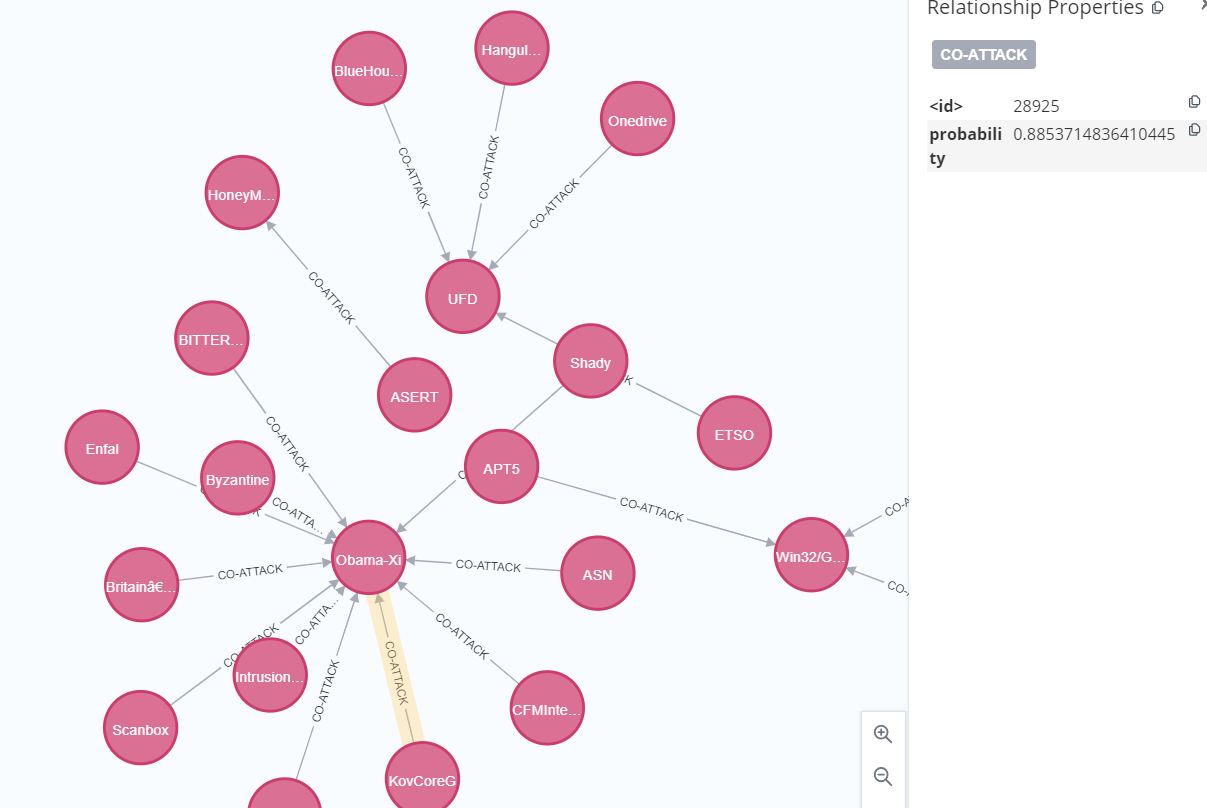

Let's answer the main question now : 

In [237]:
q="""
MATCH (a1:Campaign)-[r:`CO_ATTACK`]-(a2:Campaign)
MATCH (a2)-[:targets]->(a3:ExploitTargetObject)
MATCH (a1)-[:targets]->(a4:ExploitTargetObject)
WHERE (a4)<>(a3)
MERGE (a1)-[p:MAY_TARGET]-(a3)
"""
graph.run(q)

(No data)

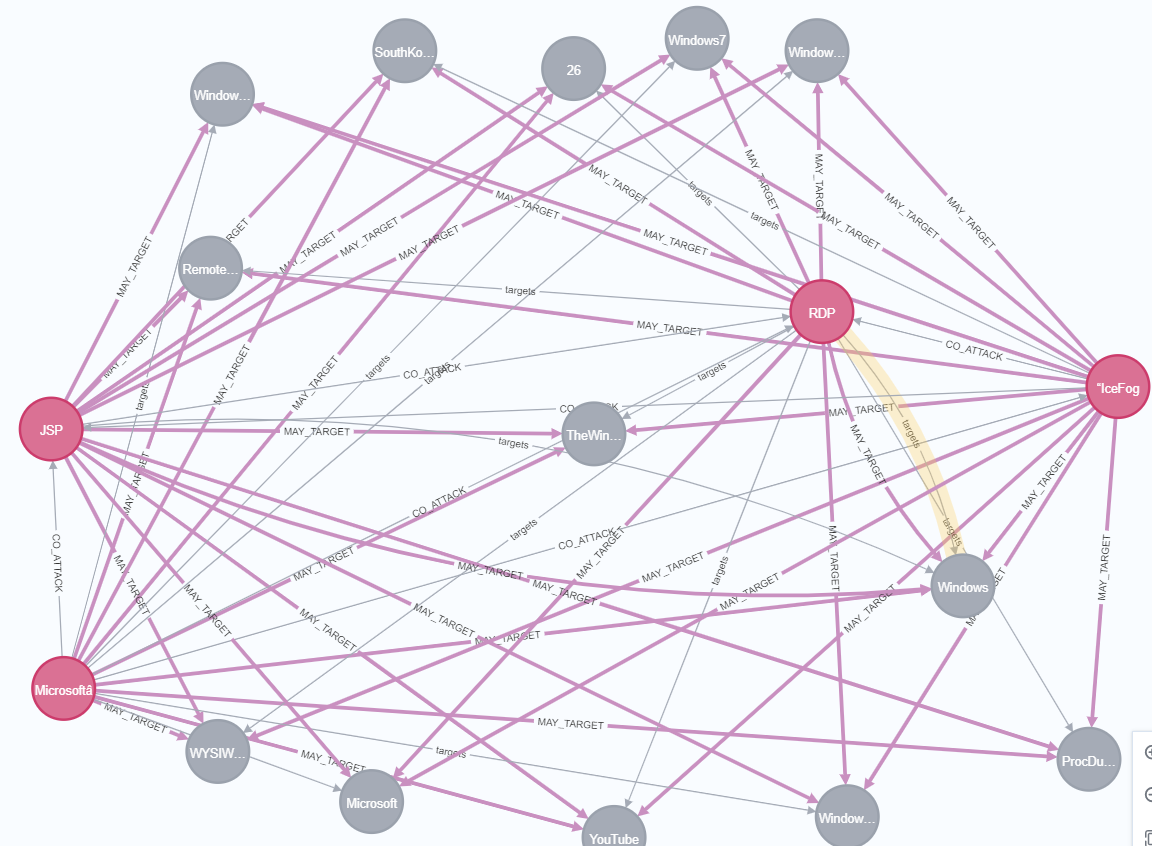

In [255]:
q="""
MATCH (a1:Campaign)-[:MAY_TARGET]->(a2:ExploitTargetObject)
RETURN a1.Name as Campaign, a2.Name as Future_Target
"""
df = pd.DataFrame(graph.query(q).to_data_frame()) 
arrays=[df['Future_Target'],df['Campaign']]
index = pd.MultiIndex.from_arrays(arrays, names=('Future_Target', 'Campaign'))
print("\nWhich exploitable target a compaign may target in the future ?")
df = pd.DataFrame(index=index)
display(df)


Which exploitable target a compaign may target in the future ?


Empty DataFrame
Columns: []
Index: [(Windows, Oce), (Windows, PlugX), (Windows, JSP), (Windows, ShadowNet), (Windows, Tranchulas), (Windows, “IceFog), (Windows, RDP), (Windows, StartProcess), (Windows, EIP), (Windows, LNK), (Windows, Talos), (Windows, ScarletMimic), (Windows, OverWatch), (Windows, FIF), (Windows, FIN6), (Windows, Avast), (Windows, POC), (Windows, Korplug), (Windows, MagicHound), (Windows, SANS), (Windows, xtremecoder), (Windows, CnC), (Windows, PaloAlto), (Windows, Stuxnet), (Windows, Trojan), (Windows, TeamViewer), (Windows, Gmail), (Windows, CurriculumVitae), (Windows, Microsoftâ), (Windows, Miniduke), (C2, Trojan), (C2, APT41), (C2, Word), (C2, StartProcess), (C2, Gmail), (C2, Packratâ), (C2, EIP), (C2, LNK), (C2, Oce), (C2, MagicHound), (C2, ScarletMimic), (C2, TeamViewer), (C2, OverWatch), (C2, Turla), (C2, FIN6), (C2, Tranchulas), (C2, CPL), (C2, PlugX), (C2, Kazuar), (C2, NetTraveler), (Quarian, RAT), (Quarian, Word), (Quarian, Packratâ), (Trojan, POC), (Trojan, Miniduke), (Trojan, OverWatch), (Trojan, TeamViewer), (Trojan, JavaDispCash), (Trojan, Tranchulas), (Trojan, FIF), (Trojan, Gmail), (Trojan, LNK), (Trojan, Korplug), (Trojan, CnC), (Trojan, ShimRat), (Trojan, FireEye), (Trojan, Oce), (Trojan, FIN6), (Trojan, CPL), (Trojan, CurriculumVitae), (Trojan, StartProcess), (Trojan, EIP), (Trojan, PlugX), (Trojan, ScarletMimic), (Trojan, PaloAlto), (Trojan, Kazuar), (VBA, ShadowNet), (VBA, CurriculumVitae), (VBA, Miniduke), (VBA, xtremecoder), (VBA, PaloAlto), (VBA, SANS), (VBA, Korplug), (VBA, CnC), (VBA, MagicHound), (VBA, FIF), (CobaltStrikeBeacon, FIF), (CobaltStrikeBeacon, CnC), (CobaltStrikeBeacon, CurriculumVitae), (CobaltStrikeBeacon, Korplug), (CobaltStrikeBeacon, PaloAlto), (CobaltStrikeBeacon, SANS), (CobaltStrikeBeacon, xtremecoder), (CobaltStrikeBeacon, Miniduke), (CobaltStrikeBeacon, MagicHound), (CobaltStrikeBeacon, ShadowNet), (AutoIt, Adobe), (AutoIt, LimaDelta), (AutoIt, LazarusGroupâ), (AutoIt, Duqu), ...]

[1068 rows x 0 columns]

## Link prediction - Method 2


In [10]:
q="""MATCH (n:ExploitTargetObject)
SET n.labelName = 'target'
RETURN n
"""
graph.run(q)

n
"(_20522:ExploitTargetObject {Name: 'Lua', labelName: 'target'})"
"(_20523:ExploitTargetObject {Name: 'BE2', labelName: 'target'})"
"(_20524:ExploitTargetObject {Name: 'Trojan.Wipbot', labelName: 'target'})"


In [11]:
q="""MATCH (n:Campaign)
SET n.labelName = 'campaign'
RETURN n
"""
graph.run(q)

n
"(_8100:Campaign {Name: 'Sofacy', labelName: 'campaign'})"
"(_8101:Campaign {Name: 'ProjectSauron', labelName: 'campaign'})"
"(_8102:Campaign {Name: 'Sauron', labelName: 'campaign'})"


In [12]:
q="""MATCH (n:ExploitTargetObject)
WHERE n.labelName IN ["target"]
WITH collect(n) AS targets
CALL apoc.refactor.rename.label("ExploitTargetObject", "Temp_node", targets)
YIELD committedOperations
RETURN committedOperations"""

graph.run(q)

committedOperations
1499


In [13]:
q="""MATCH (n:Campaign)
WHERE n.labelName IN ["campaign"]
WITH collect(n) AS camp
CALL apoc.refactor.rename.label("Campaign", "Temp_node", camp)
YIELD committedOperations
RETURN committedOperations"""

graph.run(q)

committedOperations
1701


### Preprocessing

In [25]:
q= """CALL gds.graph.project(
  'pre_projection',
['Attacker','DATE','Temp_node','Features','Groups','Indicator','Information','Location','Malware','Mitigations','Product','Tactics','Techniques','Vulnerability'],
  {
    belongsto: {
      type: 'belongsto',
      orientation: 'NATURAL'
    },
    prevents: {
      type: 'Prevents',
      orientation: 'NATURAL'
    },
      accomplishes: {
      type: 'Accomplishes',
      orientation: 'NATURAL'
    },
      step: {
      type: 'Step',
      orientation: 'NATURAL'
    },
      uses: {
      type: 'Uses',
      orientation: 'NATURAL'
    },
      associatedto: {
      type: 'associatedTo',
      orientation: 'NATURAL'
    },
      authored: {
      type: 'authored',
      orientation: 'NATURAL'
    },
      exploits: {
      type: 'exploits',
      orientation: 'NATURAL'
    },
      hasattacklocation: {
      type: 'hasattacklocation',
      orientation: 'NATURAL'
    },
      hasattacktime: {
      type: 'hasattacktime',
      orientation: 'NATURAL'
    },
      hascharacteristics: {
      type: 'hascharacteristics',
      orientation: 'NATURAL'
    },
      hasproduct: {
      type: 'hasproduct',
      orientation: 'NATURAL'
    },
      hasvulnerability: {
      type: 'hasvulnerability',
      orientation: 'NATURAL'
    },
      indicates: {
      type: 'indicates',
      orientation: 'NATURAL'
    },
      involvesmalware: {
      type: 'involvesmalware',
      orientation: 'NATURAL'
    },
      targets: {
      type: 'targets',
      orientation: 'UNDIRECTED'
    },
      usesmalware: {
      type: 'usesmalware',
      orientation: 'NATURAL'
    }
  }
) YIELD nodeCount, relationshipCount """

graph.run(q)

nodeCount,relationshipCount
20486,27835


Since we have already projected the entire graph at the beginning, let's mutate the graph project with fastRP embedding

### Fast Random Projection Embedding

Fast Random Projection (FastRP) is a scalable and performant node-embedding algorithm. It generates node embeddings (vectors) of low dimensionality through random projections from the graph’s adjacency matrix (a high-dimensional matrix) to a low-dimensional matrix, significantly reducing the computing power required to process the data.

**Why FastRP embedding ?**

This algorithm is especially useful in the following situations:

- Your data is in such high dimension that it is too expensive to perform calculations.

- The dimensionality is very high and the number of samples are too sparse to calculate covariances.

- You don’t have access to the entire dataset, such as when working with real-time data.

In [26]:
q="""
CALL gds.fastRP.mutate(
  'pre_projection',
  {
    mutateProperty: 'embedding',
    relationshipTypes: ['belongsto' , 'targets','involvesmalware','accomplishes','prevents','step','uses','associatedto','authored','exploits','hasattacklocation','hasattacktime','hascharacteristics','hasproduct','hasvulnerability','indicates','usesmalware'],
    iterationWeights: [0.0, 1.0, 0.7, 0.5, 0.5, 0.4],
    embeddingDimension: 128,
    randomSeed: 7474
  }
) YIELD nodePropertiesWritten, computeMillis;"""

graph.run(q)

nodePropertiesWritten,computeMillis
20486,66


#### Configure Link Prediction Pipeline

In [ ]:
q="""CALL gds.beta.pipeline.linkPrediction.create('er-pipe');
"""

graph.run(q)

add l2 link feature

In [17]:
q="""CALL gds.beta.pipeline.linkPrediction.addFeature(
  'er-pipe',
  'l2',
  {
    nodeProperties: ['embedding']
  }
) YIELD featureSteps;"""

graph.run(q)

featureSteps
"[{name: 'L2', config: {nodeProperties: ['embedding']}}]"


add cosin link feature

In [18]:
q="""CALL gds.beta.pipeline.linkPrediction.addFeature(
  'er-pipe',
  'cosine',
  {
    nodeProperties: ['embedding']
  }
) YIELD featureSteps;"""

graph.run(q)

featureSteps
"[{name: 'L2', config: {nodeProperties: ['embedding']}}, {name: 'COSINE', config: {nodeProperties: ['embedding']}}]"


configure relationship splits

In [19]:
q="""CALL gds.beta.pipeline.linkPrediction.configureSplit(
  'er-pipe',
  {
    testFraction: 0.25,
    trainFraction: 0.75,
    negativeSamplingRatio: 10,
    validationFolds: 5
  }
) YIELD splitConfig;"""

graph.run(q)

splitConfig
"{negativeSamplingRatio: 10.0, testFraction: 0.25, validationFolds: 5, trainFraction: 0.75}"


Configure model parameters

In [20]:
q="""CALL gds.beta.pipeline.linkPrediction.addLogisticRegression(
  'er-pipe',
  {
    penalty: 0.0,
    patience: 3,
    maxEpochs: 2000,
    tolerance: 0.00001
  }
) YIELD parameterSpace;"""

graph.run(q)

parameterSpace
"{RandomForest: [], LogisticRegression: [{maxEpochs: 2000, minEpochs: 1, penalty: 0.0, patience: 3, methodName: 'LogisticRegression', batchSize: 100, tolerance: 1e-05, learningRate: 0.001}]}"


In [21]:
q="""CALL gds.beta.pipeline.linkPrediction.addLogisticRegression(
  'er-pipe',
  {
    penalty: 0.01,
    patience: 3,
    maxEpochs: 1000,
    tolerance: 0.00001
  }
) YIELD parameterSpace;"""

graph.run(q)

parameterSpace
"{RandomForest: [], LogisticRegression: [{maxEpochs: 2000, minEpochs: 1, penalty: 0.0, patience: 3, methodName: 'LogisticRegression', batchSize: 100, tolerance: 1e-05, learningRate: 0.001}, {maxEpochs: 1000, minEpochs: 1, penalty: 0.01, patience: 3, methodName: 'LogisticRegression', batchSize: 100, tolerance: 1e-05, learningRate: 0.001}]}"


In [22]:
q="""CALL gds.beta.pipeline.linkPrediction.addLogisticRegression(
  'er-pipe',
  {
    penalty: 1.0,
    patience: 3,
    maxEpochs: 1000,
    tolerance: 0.00001
  }
) YIELD parameterSpace;"""

graph.run(q)

parameterSpace
"{RandomForest: [], LogisticRegression: [{maxEpochs: 2000, minEpochs: 1, penalty: 0.0, patience: 3, methodName: 'LogisticRegression', batchSize: 100, tolerance: 1e-05, learningRate: 0.001}, {maxEpochs: 1000, minEpochs: 1, penalty: 0.01, patience: 3, methodName: 'LogisticRegression', batchSize: 100, tolerance: 1e-05, learningRate: 0.001}, {maxEpochs: 1000, minEpochs: 1, penalty: 1.0, patience: 3, methodName: 'LogisticRegression', batchSize: 100, tolerance: 1e-05, learningRate: 0.001}]}"


### Train model

In [29]:
q="""CALL gds.beta.pipeline.linkPrediction.train(
  'pre_projection',
  {
    modelName: 'entity-linkage',
    pipeline: 'er-pipe',
    randomSeed: 7474,
    concurrency: 4,
    nodeLabels: ['Temp_node'],
    relationshipTypes: ['targets'],
    negativeClassWeight: 1.0/10.0
  }
) YIELD modelInfo
RETURN
    modelInfo.bestParameters AS winningModel,
    modelInfo.metrics.AUCPR.outerTrain AS trainGraphScore,
    modelInfo.metrics.AUCPR.test AS testGraphScore;"""

graph.run(q)

winningModel,trainGraphScore,testGraphScore
"{maxEpochs: 2000, minEpochs: 1, penalty: 0.0, patience: 3, methodName: 'LogisticRegression', batchSize: 100, tolerance: 1e-05, learningRate: 0.001}",0.9955169099050374,0.9973385263785253


### Use pipeline for prediction

In [30]:
q="""CALL gds.beta.pipeline.linkPrediction.predict.mutate(
  'pre_projection',
  {
    modelName: 'entity-linkage',
    mutateRelationshipType: 'MayTarget',
    nodeLabels: ['Temp_node'],
    relationshipTypes: ['targets'],
    topN: 500,
    threshold: 0.0
  }
);"""

graph.run(q)

relationshipsWritten,probabilityDistribution,samplingStats,mutateMillis,postProcessingMillis,preProcessingMillis,computeMillis,configuration
400,"{p1: 0.8633193969726562, max: 0.8633193969726562, p5: 0.8633193969726562, p90: 0.8633193969726562, p50: 0.8633193969726562, p95: 0.8633193969726562, p10: 0.8633193969726562, p75: 0.8633193969726562, p99: 0.8633193969726562, p25: 0.8633193969726562, p100: 0.8633193969726562, min: 0.8633193969726562, mean: 0.8633193969726562, stdDev: 0.0}","{linksConsidered: 5115809, strategy: 'exhaustive'}",0,0,0,3585,"{threshold: 0.0, sampleRate: 1.0, mutateRelationshipType: 'MayTarget', topN: 200, concurrency: 4, graphName: 'pre_projection', jobId: '00d7c1a2-a01e-4333-8858-5711eb14f0f5', modelName: 'entity-linkage', nodeLabels: ['Temp_node'], sudo: false, relationshipTypes: ['targets'], mutateProperty: 'probability', username: null}"


In [31]:
q="""CALL gds.graph.writeRelationship('pre_projection', 'MayTarget', 'probability');"""

graph.run(q)

writeMillis,graphName,relationshipType,relationshipProperty,relationshipsWritten,propertiesWritten
114,pre_projection,MayTarget,probability,400,400


Undirected relationships will have a relationship for each direction, we only need one

In [33]:
q="""MATCH (n:Temp_node)-[r:MayTarget]->(m:Temp_node) 
WHERE n.labelName=m.labelName
DELETE r;"""

graph.run(q)

(No data)

In [34]:
q="""MATCH (n:Temp_node)-[r:MayTarget]->(m:Temp_node) 
WHERE n.labelName='target' and m.labelName='campaign'
DELETE r;
"""

graph.run(q)

(No data)

Let's answer the main question now : 

In [35]:
q="""MATCH (n:Temp_node)
WHERE n.labelName IN ['campaign']
WITH collect(n) AS camp
CALL apoc.refactor.rename.label("Temp_node", "Campaign", camp)
YIELD committedOperations
RETURN committedOperations"""

graph.run(q)

committedOperations
1701


In [36]:
q="""MATCH (n:Temp_node)
WHERE n.labelName IN ["target"]
WITH collect(n) AS targets
CALL apoc.refactor.rename.label("Temp_node","ExploitTargetObject", targets)
YIELD committedOperations
RETURN committedOperations"""

graph.run(q)

committedOperations
1499


In [37]:
q="""
MATCH (a1:Campaign)-[r:MayTarget]->(a2:ExploitTargetObject)
RETURN a1.Name as Campaign, a2.Name as Future_Target, r.probability as probability
"""
df = pd.DataFrame(graph.query(q).to_data_frame()) 
arrays=[df['Future_Target'],df['Campaign'], df['probability']]
index = pd.MultiIndex.from_arrays(arrays, names=('Future_Target', 'Campaign','probability'))
print("\nWhich exploitable target a compaign may target in the future ?")
df = pd.DataFrame(index=index)
display(df)


Which exploitable target a compaign may target in the future ?


,,
Future_Target,Campaign,probability
Downdelph,LoJax,0.863323
Downdelphâ,LoJax,0.863323
PawnStorm,LoJax,0.863323
Ammyy,CARBONSPIDER,0.863323
dozens,CARBONSPIDER,0.863323
WindowsServer2003,CARBONSPIDER,0.863323
MAGNALLIUM,RASPITE,0.863323


### The organisation have noticed a clue or evidence of a data breach: what tools are being used in the attack ? what should be done to stop the attack?


En se basant sur l'évidence , il faudra trouver les techniques utilisées ou seront utilisées durant le processus d'attaque. Ainsi que les actions qui doivent être prise pour contrer l'attaque. 

Evidence = Indicator ( au niveau du graphe )

Je prendrai comme évidence trouvée le fichier 'ShadowForce32-bitEXE' qui est considéré un fichier malveillant. Puis, j'essaierai d'obtenir toutes les techniques qui seront optées par l'attaqueur durant son processus d'attaque, ainsi que les actions (Mitigations) qui permettront d'interrompre son processus. ( Pour qu'il ne puisse pas atteindre son objectif final )

Il faudra donc parcourir le chemin suivant : ( Sachant que les types de relations existantes sont : **one-to-many ou many-to-many** )



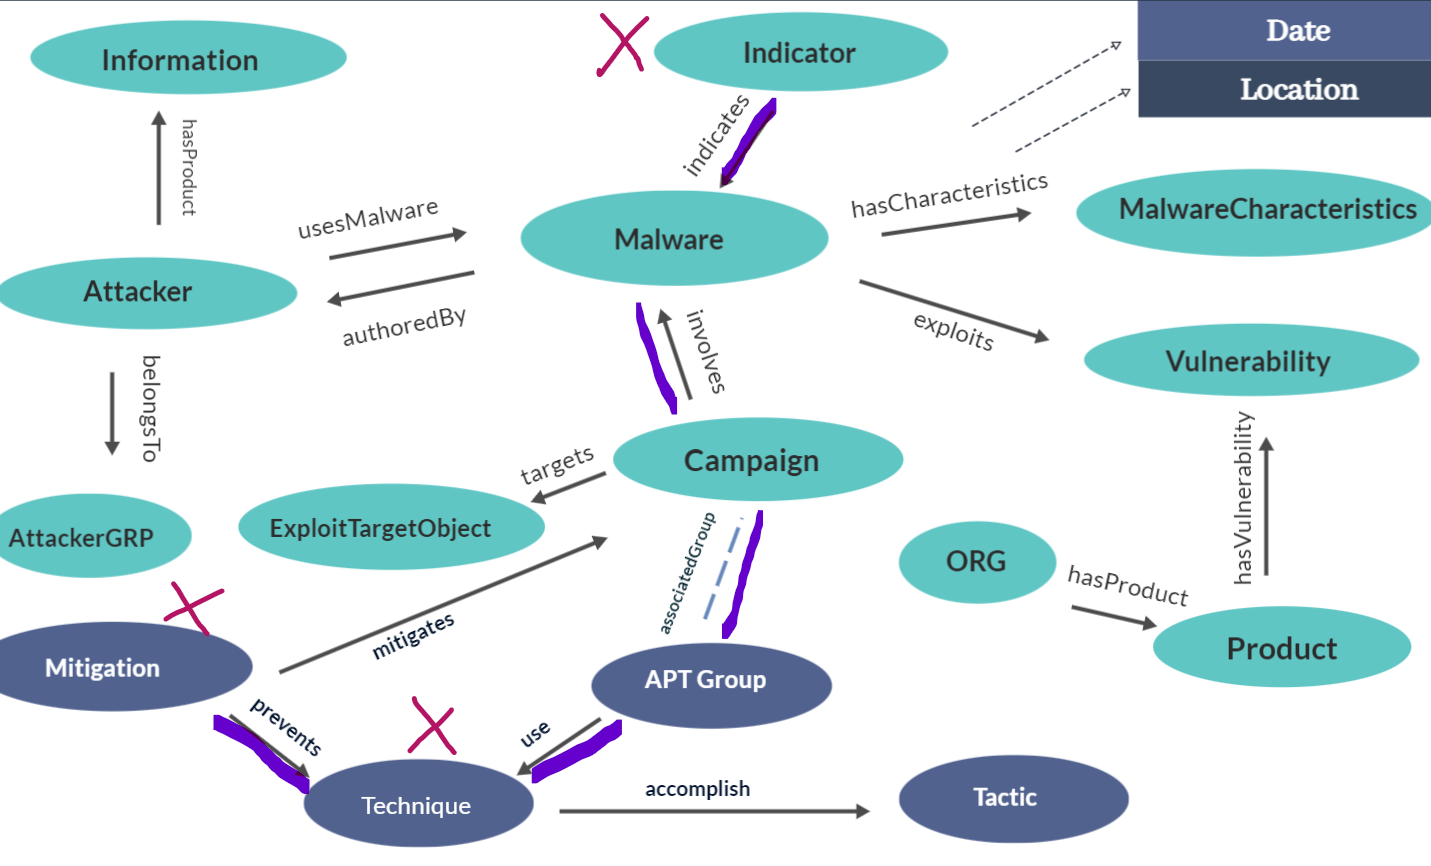


### Path finding : Depth First Search

The Depth First Search algorithm is a graph traversal that starts at a given node and explores as far as possible along each branch before backtracking, see https://en.wikipedia.org/wiki/Depth-first_search. A related algorithm is the Breath First Search algorithm, Breath First Search. This algorithm can be preferred over Breath First Search for example if one wants to find a target node at a large distance and exploring a random path has decent probability of success. There are multiple termination conditions supported for the traversal, based on either reaching one of several target nodes, reaching a maximum depth, exhausting a given budget of traversed relationship cost, or just traversing the whole graph. The output of the procedure contains information about which nodes were visited and in what order.

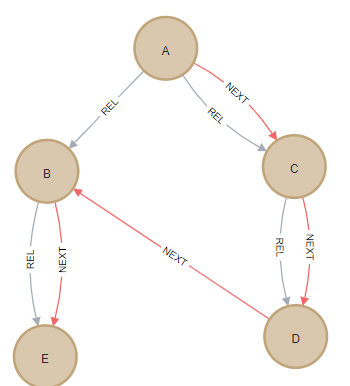

In [346]:
q="""CALL gds.beta.graph.project.subgraph(
  'path1',
  'projectgraph',
  'n:Indicator OR n:Malware OR n:Campaign OR n:Groups OR n:Techniques OR n:Mitigations',
  'r:indicates OR r:involvesmalware OR r:associatedto OR r:uses OR r:prevents'
)
YIELD graphName, fromGraphName, nodeCount, relationshipCount
"""

graph.run(q)

graphName,fromGraphName,nodeCount,relationshipCount
path1,projectgraph,6225,5631


In [347]:
q="""MATCH (source:Indicator {Name: 'ShadowForce32-bitEXE'})
CALL gds.dfs.stream.estimate('path1', {
  sourceNode: source
})
YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory
RETURN nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory"""

graph.run(q)

nodeCount,relationshipCount,bytesMin,bytesMax,requiredMemory
6225,5631,200256,200256,195 KiB


In [348]:
q="""MATCH (source:Indicator {Name:'ShadowForce32-bitEXE'})
CALL gds.dfs.stream('path1', {
  sourceNode: source
})
YIELD sourceNode, nodeIds,  path
MATCH (t:Techniques)
MATCH (mi:Mitigations)
WHERE [nodeId IN nodeIds | gds.util.asNode(nodeId).Name=t.Name] AND [nodeId IN nodeIds | gds.util.asNode(nodeId).Name=mi.Name]
RETURN
    gds.util.asNode(sourceNode).Name AS sourceNodeName,
    t.Name AS Techniques_used_by_attackers,
    mi.Name AS Mitigations
"""

df = pd.DataFrame(graph.query(q).to_data_frame()) 
arrays=[df['sourceNodeName'],df['Techniques_used_by_attackers'],df['Mitigations']]
index = pd.MultiIndex.from_arrays(arrays, names=('sourceNodeName', 'Techniques_used_by_attackers','Mitigations'))
print("\n The organisation have noticed a clue or evidence of a data breach, what tools are being used in the attack ? what should be done to stop the attack?")
data= pd.DataFrame(index=index)
display(data)


 The organisation have noticed a clue or evidence of a data breach, what tools are being used in the attack ? what should be done to stop the attack?


Empty DataFrame
Columns: []
Index: [(ShadowForce32-bitEXE, Drive-by Compromise,  Account Use Policies ), (ShadowForce32-bitEXE, Drive-by Compromise,  Active Directory Configuration ), (ShadowForce32-bitEXE, Drive-by Compromise,  Antivirus/Antimalware ), (ShadowForce32-bitEXE, Drive-by Compromise,  Application Developer Guidance ), (ShadowForce32-bitEXE, Drive-by Compromise,  Application Isolation and Sandboxing ), (ShadowForce32-bitEXE, Drive-by Compromise,  Audit ), (ShadowForce32-bitEXE, Drive-by Compromise,  Behavior Prevention on Endpoint ), (ShadowForce32-bitEXE, Drive-by Compromise,  Boot Integrity ), (ShadowForce32-bitEXE, Drive-by Compromise,  Code Signing ), (ShadowForce32-bitEXE, Drive-by Compromise,  Credential Access Protection ), (ShadowForce32-bitEXE, Drive-by Compromise,  Data Backup ), (ShadowForce32-bitEXE, Drive-by Compromise,  Disable or Remove Feature or Program ), (ShadowForce32-bitEXE, Drive-by Compromise,  Do Not Mitigate ), (ShadowForce32-bitEXE, Drive-by Compromise,  Encrypt Sensitive Information ), (ShadowForce32-bitEXE, Drive-by Compromise,  Environment Variable Permissions ), (ShadowForce32-bitEXE, Drive-by Compromise,  Execution Prevention ), (ShadowForce32-bitEXE, Drive-by Compromise,  Exploit Protection ), (ShadowForce32-bitEXE, Drive-by Compromise,  Filter Network Traffic ), (ShadowForce32-bitEXE, Drive-by Compromise,  Limit Access to Resource Over Network ), (ShadowForce32-bitEXE, Drive-by Compromise,  Limit Hardware Installation ), (ShadowForce32-bitEXE, Drive-by Compromise,  Limit Software Installation ), (ShadowForce32-bitEXE, Drive-by Compromise,  Multi-factor Authentication ), (ShadowForce32-bitEXE, Drive-by Compromise,  Network Intrusion Prevention ), (ShadowForce32-bitEXE, Drive-by Compromise,  Network Segmentation ), (ShadowForce32-bitEXE, Drive-by Compromise,  Operating System Configuration ), (ShadowForce32-bitEXE, Drive-by Compromise,  Password Policies ), (ShadowForce32-bitEXE, Drive-by Compromise,  Pre-compromise ), (ShadowForce32-bitEXE, Drive-by Compromise,  Privileged Account Management ), (ShadowForce32-bitEXE, Drive-by Compromise,  Privileged Process Integrity ), (ShadowForce32-bitEXE, Drive-by Compromise,  Remote Data Storage ), (ShadowForce32-bitEXE, Drive-by Compromise,  Restrict File and Directory Permissions ), (ShadowForce32-bitEXE, Drive-by Compromise,  Restrict Library Loading ), (ShadowForce32-bitEXE, Drive-by Compromise,  Restrict Registry Permissions ), (ShadowForce32-bitEXE, Drive-by Compromise,  Restrict Web-Based Content ), (ShadowForce32-bitEXE, Drive-by Compromise,  Software Configuration ), (ShadowForce32-bitEXE, Drive-by Compromise,  SSL/TLS Inspection ), (ShadowForce32-bitEXE, Drive-by Compromise,  Threat Intelligence Program ), (ShadowForce32-bitEXE, Drive-by Compromise,  Update Software ), (ShadowForce32-bitEXE, Drive-by Compromise,  User Account Control ), (ShadowForce32-bitEXE, Drive-by Compromise,  User Account Management ), (ShadowForce32-bitEXE, Drive-by Compromise,  User Training ), (ShadowForce32-bitEXE, Drive-by Compromise,  Vulnerability Scanning ), (ShadowForce32-bitEXE, Exploit Public-Facing Application,  Account Use Policies ), (ShadowForce32-bitEXE, Exploit Public-Facing Application,  Active Directory Configuration ), (ShadowForce32-bitEXE, Exploit Public-Facing Application,  Antivirus/Antimalware ), (ShadowForce32-bitEXE, Exploit Public-Facing Application,  Application Developer Guidance ), (ShadowForce32-bitEXE, Exploit Public-Facing Application,  Application Isolation and Sandboxing ), (ShadowForce32-bitEXE, Exploit Public-Facing Application,  Audit ), (ShadowForce32-bitEXE, Exploit Public-Facing Application,  Behavior Prevention on Endpoint ), (ShadowForce32-bitEXE, Exploit Public-Facing Application,  Boot Integrity ), (ShadowForce32-bitEXE, Exploit Public-Facing Application,  Code Signing ), (ShadowForce32-bitEXE, Exploit Public-Facing Application,  Credential Access Protection ), (ShadowForce32-bitEXE, Exploit Public-Facing Application, 

J'ai reçu plusieurs techniques qui peuvent être opter par le pirate informatique durant l'attaque, **ça serait préferable de commencer le traitement par quels techniques?**

**Solution** : Prendre en consideration l'entité "Tactics", qui contient le processus d'attaque, et puis de faire une projection d'un sous-graph qui ne va contenir que les noeuds : Techniques et Tactics, ensuite il va falloir calculer pour chaque technique le 'closeness score' : plus grand est le score, plus critique la technique sera considérée puisque ça signifie qu'elle sera executée non juste au niveau d'une seule étape mais plusieurs. Donc en traitant les techniques (obtenues précedemment ) avec un score élevées les premiers, on aura plus de chance d'interrompre l'attacker -> "**Kill the cyber-attack chain**" 

Noeuds rouges : Techniques , Noeuds marrons : Tactics


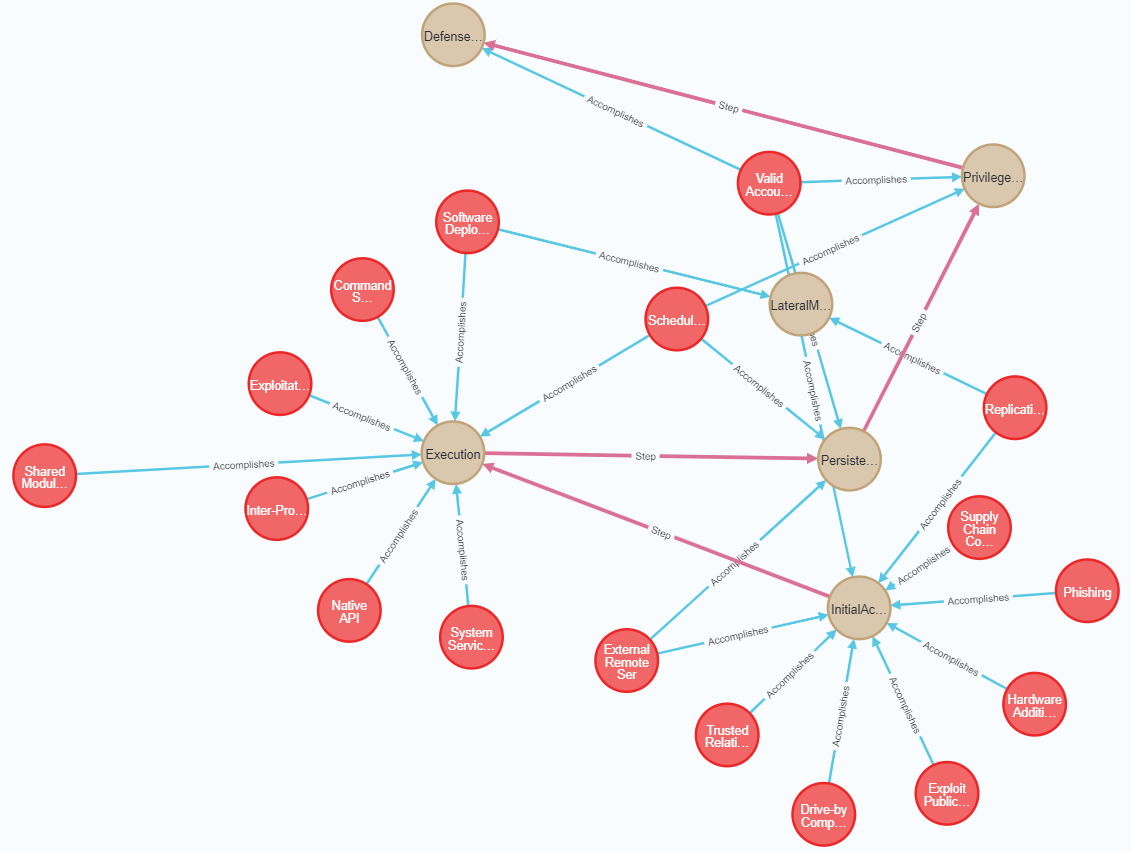

### Closeness Centrality

Closeness centrality is a way of detecting nodes that are able to spread information very efficiently through a graph.

The closeness centrality of a node measures its average farness (inverse distance) to all other nodes. Nodes with a high closeness score have the shortest distances to all other nodes.

In [330]:
q="""CALL gds.beta.graph.project.subgraph(
  'importance_',
  'project_graph',
  'n:Tactics OR n:Techniques',
  'r:accomplishes OR r:step'
)
YIELD graphName, fromGraphName, nodeCount, relationshipCount
"""

graph.run(q)

graphName,fromGraphName,nodeCount,relationshipCount
importance_,project_graph,173,389


Je vais me focaliser que sur les techniques concernant l'évidence trouvée 'ShadowForce32-bitEXE'. Mais la meme méthode peut s'appliquer sur n'importe quel type d'évidence.

In [349]:
q="""CALL gds.beta.closeness.stream('importance_')
YIELD nodeId, score
WHERE gds.util.asNode(nodeId).Name IN """+ str(df['Techniques_used_by_attackers'].unique().tolist()) +""" 

RETURN gds.util.asNode(nodeId).Name AS Techniques_used_by_attackers, score as importance 
ORDER BY importance DESC"""

df1 = pd.DataFrame(graph.query(q).to_data_frame()) 
display(df1.head())

,Techniques_used_by_attackers,importance
0,Traffic Signaling,0.339785
1,Virtualization/Sandbox Evasion,0.308594
2,Valid Accounts,0.297552
3,Modify Authentication Process,0.297552
4,Use Alternate Authentication Material,0.293135


#### Update Data : pour meilleur lisibilité

In [355]:
q="""CALL gds.beta.closeness.stream('importance_')
YIELD nodeId, score
WHERE gds.util.asNode(nodeId).Name IN """+ str(df['Techniques_used_by_attackers'].unique().tolist()) +""" 

RETURN gds.util.asNode(nodeId).Name AS Techniques_used_by_attackers, score as importance 
"""

df2 = pd.DataFrame(graph.query(q).to_data_frame()) 
display(df2.head())

,Techniques_used_by_attackers,importance
0,Drive-by Compromise,0.200253
1,Exploit Public-Facing Application,0.200253
2,External Remote Services,0.242331
3,Hardware Additions,0.200253
4,Phishing,0.200253


In [357]:
df['Priorité']=0
for i in range (df2.shape[0]):
    df.loc[df.Techniques_used_by_attackers==df2['Techniques_used_by_attackers'][i], 'Priorité']=df2['importance'][i]

In [362]:
df=df.sort_values(by='Priorité', ascending=False)

In [361]:
arrays=[df['sourceNodeName'],df['Techniques_used_by_attackers'],df['Priorité'], df['Mitigations']]
index = pd.MultiIndex.from_arrays(arrays, names=('sourceNodeName', 'Techniques_used_by_attackers','Priority', 'Mitigations'))
data= pd.DataFrame(index=index)
display(data)

Empty DataFrame
Columns: []
Index: [(ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Network Segmentation ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Behavior Prevention on Endpoint ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Restrict File and Directory Permissions ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Remote Data Storage ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Privileged Process Integrity ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Privileged Account Management ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Pre-compromise ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Password Policies ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Operating System Configuration ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Audit ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Network Intrusion Prevention ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Multi-factor Authentication ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Limit Software Installation ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Limit Hardware Installation ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Limit Access to Resource Over Network ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Filter Network Traffic ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Exploit Protection ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Execution Prevention ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Environment Variable Permissions ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Encrypt Sensitive Information ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Do Not Mitigate ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Disable or Remove Feature or Program ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Data Backup ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Credential Access Protection ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Code Signing ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Restrict Library Loading ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Restrict Registry Permissions ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Restrict Web-Based Content ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Vulnerability Scanning ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Account Use Policies ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Software Configuration ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Antivirus/Antimalware ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Application Developer Guidance ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Application Isolation and Sandboxing ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Active Directory Configuration ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  User Training ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Threat Intelligence Program ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  User Account Management ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  SSL/TLS Inspection ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Boot Integrity ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  Update Software ), (ShadowForce32-bitEXE, Traffic Signaling, 0.33978494623655914,  User Account Control ), (ShadowForce32-bitEXE, Virtualization/Sandbox Evasion, 0.30859375,  Network Intrusion Prevention ), (ShadowForce32-bi